In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
path='/Users/aman/Downloads/food_orders_new_delhi (1).csv'
data=pd.read_csv(path)
data.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


**Detailed Cost Analysis:**
dentify the major cost components and calculate the sum of (total costs for each order).

In [21]:

#For Extracting Numeric Data From Column Discount Having Data like 50% on App, 50 off etc.
#To do so, def a function extract_numeric
#Function to extract numeric values and handle percentages
def extract_numeric(row):
    discount_offer = str(row['Discounts and Offers'])  # Ensure the value is treated as a string
    order_value = row['Order Value']
    
    # Extract numeric part and percentage sign if present
    match = pd.Series(discount_offer).str.extract(r'(\d+)(%)?', expand=False)
    # Convert the numeric part to a float
    num = pd.to_numeric(match[0], errors='coerce')
    # Calculate the discount amount
    discount_amount = num.where(match[1] != '%', num * order_value / 100)
    return discount_amount.iloc[0]

# Apply the function to each row using .apply with axis=1
data['Discount Cost'] = data.apply(extract_numeric, axis=1)
data['Delivery Cost'] = data['Delivery Fee']
#data['Commission Fee']=data['Commission Fee']
data['Payment Processing Cost'] = data['Payment Processing Fee']
#data['Refunds/Chargebacks']=data['Refunds/Chargebacks']

data['Total Costs'] = (
                    data['Delivery Cost'] + 
                    data['Discount Cost'].fillna(0) + 
                    data['Payment Processing Cost']
                    #+data['Commission Fee']
                    #+data['Refunds/Chargebacks']
                    )

# Summarize cost components
cost_summary = data[[
                    'Delivery Cost', 
                    'Discount Cost', 
                    'Payment Processing Cost',
                    'Commission Fee', 
                    'Refunds/Chargebacks',
                    'Total Costs']].head()
cost_summary_total = data[[
                    'Delivery Cost', 
                    'Discount Cost', 
                    'Payment Processing Cost',
                    #'Commission Fee', 
                    #'Refunds/Chargebacks',
                    'Total Costs']].sum()

print(cost_summary,cost_summary_total,sep='\n')

#print(data.head())

   Delivery Cost  Discount Cost  Payment Processing Cost  Commission Fee  \
0              0          95.70                       47             150   
1             40          98.60                       23             198   
2             30         140.55                       45             195   
3             50            NaN                       27             146   
4             30          50.00                       50             130   

   Refunds/Chargebacks  Total Costs  
0                    0       142.70  
1                    0       161.60  
2                    0       215.55  
3                    0        77.00  
4                    0       130.00  
Delivery Cost               28620.00
Discount Cost               74289.85
Payment Processing Cost     29832.00
Total Costs                132741.85
dtype: float64


**Profitability Evaluation:**
Calculate the profitability for each order and overall profitability.

In [22]:
# Calculate revenue
data['Revenue'] = data['Commission Fee']

# Calculate profitability per order
data['Profit'] = data['Revenue'] - data['Total Costs'] - data['Refunds/Chargebacks']


# Profitability per order
profit_summary = data[['Order ID', 'Order Value','Commission Fee', 
                    'Refunds/Chargebacks','Profit','Total Costs']].head()
print(profit_summary)

# Overall profitability
#total_profit = data['Profit'].sum()
profit_summary_total = data[['Order Value','Revenue','Profit','Total Costs','Refunds/Chargebacks']].sum()
print(profit_summary_total)


   Order ID  Order Value  Commission Fee  Refunds/Chargebacks  Profit  \
0         1         1914             150                    0    7.30   
1         2          986             198                    0   36.40   
2         3          937             195                    0  -20.55   
3         4         1463             146                    0   69.00   
4         5         1992             130                    0    0.00   

   Total Costs  
0       142.70  
1       161.60  
2       215.55  
3        77.00  
4       130.00  
Order Value            1053969.00
Revenue                 126990.00
Profit                  -34051.85
Total Costs             132741.85
Refunds/Chargebacks      28300.00
dtype: float64


**Strategic Recommendations for Improvement:**
Analyze the data to find potential adjustments in pricing, commission fees, and discount strategies.

Average Commission Rate:  12.049 %
Average Discount Rate:    8.649 % 

Sweet Spot - Commission Rate: 30.75%, Discount Rate: 5.00%, Max Profit: 184,645.018


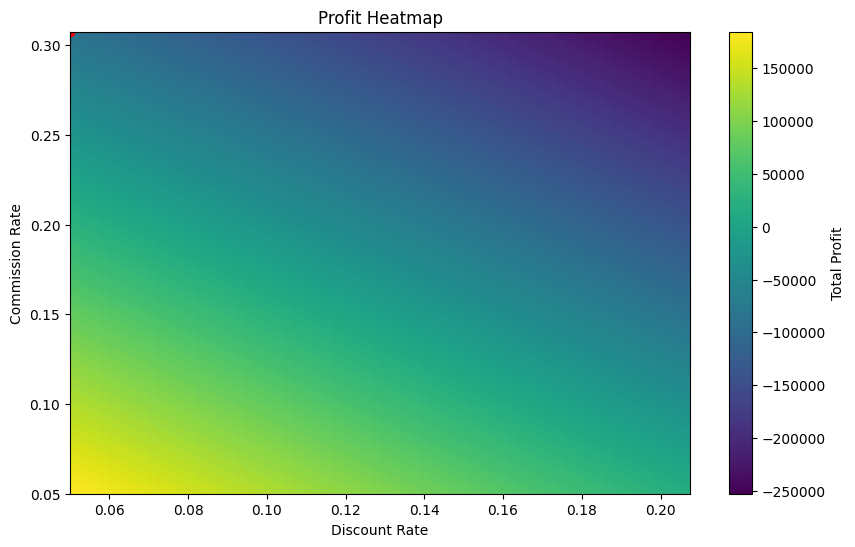

In [23]:
# Find current average commission and discount rates
avg_commission_rate = data['Commission Fee'].mean() / data['Order Value'].mean()
avg_discount_rate = data['Discount Cost'].mean() / data['Order Value'].mean()

print('Average Commission Rate:  {:.3f} %'.format(avg_commission_rate*100))
print('Average Discount Rate:    {:.3f} %'.format(avg_discount_rate*100),'\n')


# Define ranges for commission and discount rates
"""np.arange(start, stop, step): 
This function generates values in a given range with a specified step size."""

commission_rates = np.arange(0.05, 0.31, 0.0025)  # 5% to 30% It does not include 31% because stop is exclusive.
discount_rates = np.arange(0.05, 0.21, 0.0025)    # 5% to 20%

best_commission_rate = 0
best_discount_rate = 0
max_profit = -np.inf
"""max_profit = -np.inf: This initializes the maximum profit to negative infinity, 
ensuring that any calculated profit will be larger."""

"""initializes a 2D array (matrix) filled with zeros. 
This matrix will be used to store the calculated profits for each combination of commission rates and discount rates."""

profit_matrix = np.zeros((len(commission_rates), len(discount_rates)))


"""1. np.zeros(shape): This function creates an array of the given shape, filled with zeros. 
The shape is specified as a tuple, indicating the dimensions of the array.

2. len(commission_rates): This returns the number of elements in the commission_rates array.

3. len(discount_rates): This returns the number of elements in the discount_rates array.
4. (len(commission_rates), len(discount_rates)): This tuple represents the dimensions of the 2D array. 
The number of rows will be equal to the number of commission rates, 
and the number of columns will be equal to the number of discount rates."""

# Function to calculate profit given commission and discount rates
def calculate_profit(data, commission_rate, discount_rate):
    data['New Commission Fee'] = data['Order Value'] * commission_rate
    data['New Discount Cost'] = data['Order Value'] * discount_rate
    data['New Total Costs'] = data['Delivery Fee'] + data['New Discount Cost'] + data['Payment Processing Fee']
    data['New Profit'] = data['New Commission Fee'] - data['New Total Costs'] - data['Refunds/Chargebacks']
    total_profit = data['New Profit'].sum()
    return total_profit



for i, commission_rate in enumerate(commission_rates):
    for j, discount_rate in enumerate(discount_rates):
        profit = calculate_profit(data, commission_rate, discount_rate)
        profit_matrix[i, j] = profit
        if profit > max_profit:
            max_profit = profit
            best_commission_rate = commission_rate
            best_discount_rate = discount_rate

print(f'Sweet Spot - Commission Rate: {best_commission_rate*100:.2f}%, Discount Rate: {best_discount_rate*100:.2f}%, Max Profit: {max_profit:,.3f}')

# Visualize the profit matrix
plt.figure(figsize=(10, 6))
plt.imshow(profit_matrix, aspect='auto', cmap='viridis', extent=[discount_rates.min(), discount_rates.max(), commission_rates.min(), commission_rates.max()])
plt.colorbar(label='Total Profit')
plt.title('Profit Heatmap')
plt.xlabel('Discount Rate')
plt.ylabel('Commission Rate')
plt.scatter([best_discount_rate], [best_commission_rate], color='red')
plt.show()







**Impact Simulation of Proposed Strategies:**
Simulate the impact of the recommended strategies on profitability.